## Опредление пола говорящего

Дан датасет с записями фразы человека (порядка 2 гБ или 14000 записей) в формате wav и целевой признак, означающий пол говорящего человека (0 – мужчина, 1 – женщина). Для тестового набора данных необходимо определить пол говорящего по записи.

Данное задание было представлено в тренировочном задании от Яндекса.

### Импорт библиотек

In [2]:
from os import listdir
from os.path import isfile, join
from os import walk
from random import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from librosa.feature import melspectrogram
import matplotlib.pyplot as plt
from tqdm import notebook

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import tensorflow as tf
from lightgbm import LGBMClassifier

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F

from sklearn.metrics import accuracy_score, f1_score

In [3]:
labels = pd.read_csv('/kaggle/input/train-audio/train — копия/targets.tsv', sep='\t')

In [4]:
labels

,5d1f7e43366513a1d0a6ec5640c3dc24,1
0,9a701a4536a05b6610a590a9fe702ed8,1
1,cad0b8547008d1524c1a0e5fd51f9908,1
2,4bbe607e7dc95460e2cc1a6ee5f4dfa6,0
3,30fb32cba90b34af26f3f14f5d636805,0
4,fa33445afe71a6dc18e4881c053da5be,0
...,...,...
13930,215443bcce2003d58d7dc6cd53af73ed,1
13931,d26e5ebee3589530a4ec735ba1baab83,0
13932,b9ae9428d4d7d279068aea06365d5736,1
13933,3da22010bcdd5b47d7f2d3ceea190195,0


Первый столбец хранит в себе название файла с записью, а второй столбец информацию о поле.


In [5]:
columns_name = '5d1f7e43366513a1d0a6ec5640c3dc24'

In [7]:
labels['1'].value_counts()

0    7620
1    6315
Name: 1, dtype: int64

## Обработка данных

Очевидно, что аудиозаписи необходимо каким-то образом обработать, для этого воспользуемся библиотекой librosa, которая изначально просто преобразует запись во временной ряд, а потом с помощью функции librosa.feature.melspectrogram создает данные для спектрограммы. Но для того, чтобы данные более чистыми, их нужно очистить от отрывков, где нет фразы.

In [10]:
data = pd.DataFrame(columns=range(64))
data['target'] = labels['1']
data

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
13931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
13932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
13933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
fig, ax = plt.subplots()
y, sr = librosa.load('datasets/biometry/train/a002fd057fc273c7c397813302aef2e0.wav')
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64,
                                    fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

Так выглядят спектрограммы без обработки по длине, видно, что фраза занимает меньше секунды, а сам файл длится около 6 секунд

In [ ]:
fig, ax = plt.subplots()
y, sr = librosa.load('datasets/biometry/train/a002fd057fc273c7c397813302aef2e0.wav')
y = np.array(y)
start = y.tolist().index(y[y > 0.01][0]) - 10 
finish = y.tolist().index(y[y > 0.01][-1]) + 10 
y = y[start:finish]
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64,
                                    fmax=8000) 
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

А вот так уже после обработки

In [ ]:
%%time
for i, name in notebook.tqdm(enumerate(labels[columns_name])):
    path = '/kaggle/input/train-audio/train — копия/' + name +'.wav'
    y, sr = librosa.load(path)
    y = np.array(y)
    start = y.tolist().index(y[y > 0.01][0]) - 10 #ищем примерное начало фразы
    finish = y.tolist().index(y[y > 0.01][-1]) + 10 #ищем примерный конец фразы
    y = y[start:finish]
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64,
                                    fmax=8000) #генерим признаки для спектрограммы
    S_dB = librosa.power_to_db(S, ref=np.max)
    for j in range(64):
        feature = sum([i ** 2 for i in S_dB[j]])
        data.loc[i, j] = feature

0it [00:00, ?it/s]

In [54]:
data

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,204411.223433,271924.86636,267873.71551,227173.582374,262679.367037,328301.186321,331672.440944,388154.990206,400028.136214,395746.428713,...,739988.595561,738253.504019,719662.953597,712143.163851,721877.156801,722858.913014,731429.026894,767929.295225,819762.264767,1
1,103478.609184,82423.321392,73206.071547,41898.590278,23907.158108,33480.870458,55273.122055,66427.019129,52431.375495,47445.520914,...,165935.27801,158384.821573,157558.213111,159589.84628,168295.296734,160575.33446,149717.909518,160427.739956,232168.0386,1
2,154512.011718,124388.612127,117048.215212,126309.491903,132987.057387,146706.480232,162241.15983,160510.188176,164394.620592,172553.735688,...,273712.05306,269513.916071,273097.080501,276054.332319,273612.146499,284109.921382,303191.091245,329499.073002,379859.827994,0
3,71889.367898,28018.258778,17174.985693,20014.468878,29998.11102,29485.429498,28282.940881,26225.361165,34504.483856,34110.55015,...,99663.081033,97522.493352,100948.404514,107279.839486,113688.712232,112848.026978,120207.364915,136073.057878,185244.448993,0
4,99306.985961,52711.005439,39407.172431,49963.221494,54690.390415,52022.892079,53641.87631,61935.778263,58261.948945,59246.381271,...,149749.415053,162875.987422,178198.605432,178439.554494,170282.641268,163353.90548,185325.37377,245424.064962,316091.798162,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13930,271848.255604,214805.504649,244871.496786,238239.490899,254982.379186,285173.732865,342562.037631,360886.218289,336752.22636,295869.829873,...,713540.022001,724758.456615,729394.135504,745733.355529,767890.776454,772633.407702,771004.386442,808736.401383,878883.73527,1
13931,324401.666579,243113.736487,297628.286398,311655.378317,329868.392546,360888.701976,395577.098582,420784.09888,388093.59853,343882.18919,...,824836.111928,818337.782277,817930.943823,817083.219884,833995.34799,852098.225604,868595.480391,897487.853746,952256.043555,0
13932,72671.349872,85552.401273,79819.461461,60620.690586,58213.009929,53147.109679,48461.639867,52561.084586,47299.062416,51194.665729,...,120098.939073,120790.34703,112804.285492,111825.193933,113158.913183,113938.022228,118707.720616,134241.786957,177461.8919,1
13933,67415.905118,21228.851634,23237.773481,25274.362376,21331.334591,34850.487147,29771.702149,36176.025479,46136.66477,51424.592347,...,140459.588801,126237.290145,119574.630452,123672.715229,127393.529964,146193.986359,149501.870465,176851.157499,219983.652663,0


Данные процесс занимает долгое время, поэтому для удобства сохраним результат в датасет, чтобы при возвращении к работе можно было быстро построить новые модели. 

In [55]:
data.to_csv('datasets/biometry/new_data.csv', index=False)

In [50]:
data = pd.read_csv('datasets/biometry/new_data.csv')

In [18]:
from os import walk
f = []
for (dirpath, dirnames, filenames) in walk('datasets/biometry/test/'):
    f.extend(filenames)
    break

В список f были сохранены данные с папки, содержащей данные для предсказания

In [11]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64,
                                    fmax=8000) 
S_dB = librosa.power_to_db(S, ref=np.max)
S_dB.shape

(64, 22)

In [21]:
test = pd.DataFrame(columns=range(64))

In [ ]:
for i, name in notebook.tqdm(enumerate(f)):
    path = 'datasets/biometry/test/' + name
    y, sr = librosa.load(path)
    y = np.array(y)
    start = y.tolist().index(y[y > 0.01][0]) - 10
    finish = y.tolist().index(y[y > 0.01][-1]) + 10
    y = y[start:finish]
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64,
                                    fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    for j in range(64):
        feature = sum([i ** 2 for i in S_dB[j]])
        test.loc[i, j] = feature

In [ ]:
test.to_csv('datasets/biometry/test_data.csv', index=False)

In [2]:
test = pd.read_csv('datasets/biometry/test_data.csv')

In [3]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,40446.260001,19377.879139,18774.686192,13187.499715,15424.532648,15952.920838,17235.950326,14922.397261,17589.377541,22550.327441,...,94711.985532,89001.118485,87710.256628,80268.926981,79368.920448,86509.367995,90454.831397,101770.536003,112131.813451,147973.116294
1,62165.922134,50606.276502,43322.794601,32391.453336,30863.603250,38656.917066,37146.428586,46275.119106,50962.128097,43004.966220,...,136487.927724,131565.665366,140939.650398,157729.552829,163548.002982,171024.194583,170470.329084,166093.087938,177104.680191,254322.981700
2,285045.110029,346036.371246,313926.985218,270639.930303,298564.197577,342315.259575,349658.789235,377927.703294,382219.148396,379931.815854,...,616304.020630,599581.381416,612549.682239,620135.406935,623685.892744,611933.647516,596796.910485,595378.951782,635943.381445,726168.770896
3,111418.688196,89161.137381,78153.801036,51104.220416,41705.879564,50807.000286,76022.464781,85403.298864,82164.164130,75659.052776,...,172671.817956,180611.061503,176372.487897,159225.272524,149458.242289,136089.909219,139194.484249,137755.406551,153684.938077,212454.686426
4,39006.600064,16419.072367,10019.357302,7790.826651,10390.488504,18406.687106,14534.264784,10894.064532,15156.837946,17149.908463,...,52545.265478,60735.640358,61779.219777,69916.849333,69752.183577,76069.291726,77925.507083,81375.696021,97013.682663,133312.197925


## Построение модели 📈

Разобьем данные в отношении 80/20

In [51]:
y = data['target']
X = data.drop('target', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

### Логистическая регрессия

In [52]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [53]:
accuracy_score(y_valid, log_reg.predict(X_valid))

0.943308216720488

In [54]:
f1_score(y_valid, log_reg.predict(X_valid))

0.935720097640358

### Catboost 😺

In [55]:
cat_cl = CatBoostClassifier(iterations=3000, verbose=False)
cat_cl.fit(X_train, y_train)

In [56]:
accuracy_score(y_valid, cat_cl.predict(X_valid))

0.9321851453175457

In [57]:
f1_score(y_valid, cat_cl.predict(X_valid))

0.9218685407193055

### LightGBM

In [104]:
lgbm = LGBMClassifier(n_estimators=500, learning_rate=0.1)
lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=500)

In [105]:
accuracy_score(y_valid, lgbm.predict(X_valid))

0.9386437029063509

In [106]:
f1_score(y_valid, lgbm.predict(X_valid))

0.9294845360824742

Данные модели не показывают желаемого качество, поэтому будет использовать сверточные нейронные сети

### Convolution NN

Так как спектрограмма выдает тензор, то чтобы достать из этого тензора максимум информации необходимо учитывать взаимодействия соседних значений тензора. Для этого отлично подойдут сверточные нейронные сети, используемые в CV. Теперь нам не требуется обрезать спектрограмму, так как нейронка сможет сама понять, где расположена интересующая ее информация за счёт pooling слоя.

In [9]:
train_dataset = []
val_dataset = []
train_files = []
val_files = []
for name in notebook.tqdm(labels[columns_name]):
    loader = random()
    path = '/kaggle/input/train-audio/train — копия/' + name +'.wav'
    y, sr = librosa.load(path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000) #генерим признаки для спектрограммы
    S_dB = torch.tensor(librosa.power_to_db(S, ref=np.max))
    S_dB = torch.cat((S_dB, torch.zeros((64, 700-len(S_dB[0])))), dim=1) #приводим тензоры к одному размеру
    if loader >= 0.2:
        train_dataset.append(S_dB)
        train_files.append(path)
    else:
        val_dataset.append(S_dB)
        val_files.append(path)

  0%|          | 0/13935 [00:00<?, ?it/s]

In [10]:
len(val_dataset) / len(train_dataset)

0.23932764140875135

In [11]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [12]:
train_data = torch.stack(train_dataset)
val_data = torch.stack(val_dataset)

In [13]:
train_data[:, None, :].shape

torch.Size([11244, 1, 64, 700])

In [25]:
train_files = [i[40:-4] for i in train_files]
val_files = [i[40:-4] for i in val_files]

In [27]:
train_dataset = TensorDataset(train_data[:, None, :], torch.tensor(labels.loc[labels[columns_name].isin(train_files), '1'].values))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataset = TensorDataset(val_data[:, None, :], torch.tensor(labels.loc[labels[columns_name].isin(val_files), '1'].values))
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=2)

In [29]:
class MyNN(nn.Module):
    def __init__(self):
        super(MyNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(29064, 128) 
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool1(F.elu(self.conv1(x)))
        x = self.pool2(F.elu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        return x

In [38]:
model = MyNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {'train': train_dataloader, 'valid': val_dataloader}

In [39]:
max_epochs = 15
accuracy = {'train': [], 'valid': []}
losses = {'train': [], 'valid': []}
for epoch in notebook.tqdm(range(max_epochs)):
    epoch_correct = 0
    epoch_all = 0
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == 'train':
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = sum(y_batch == preds)
            all = 128
            epoch_correct += correct
            epoch_all += all
            if k == 'train':
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        losses[k].append(loss.cpu().detach().numpy())
        accuracy[k].append((epoch_correct / epoch_all).cpu())
        print(f'Epoch {epoch} {k} loss: {loss}')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 train loss: 0.179587721824646
Epoch 0 valid loss: 0.179587721824646
Epoch 1 train loss: 0.1698330193758011
Epoch 1 valid loss: 0.1698330193758011
Epoch 2 train loss: 0.06362909078598022
Epoch 2 valid loss: 0.06362909078598022
Epoch 3 train loss: 0.11488744616508484
Epoch 3 valid loss: 0.11488744616508484
Epoch 4 train loss: 0.05617386847734451
Epoch 4 valid loss: 0.05617386847734451
Epoch 5 train loss: 0.03906169533729553
Epoch 5 valid loss: 0.03906169533729553
Epoch 6 train loss: 0.0889773964881897
Epoch 6 valid loss: 0.0889773964881897
Epoch 7 train loss: 0.06378895044326782
Epoch 7 valid loss: 0.06378895044326782
Epoch 8 train loss: 0.022101717069745064
Epoch 8 valid loss: 0.022101717069745064
Epoch 9 train loss: 0.0026232192758470774
Epoch 9 valid loss: 0.0026232192758470774
Epoch 10 train loss: 0.0007612652261741459
Epoch 10 valid loss: 0.0007612652261741459
Epoch 11 train loss: 0.0008190431981347501
Epoch 11 valid loss: 0.0008190431981347501
Epoch 12 train loss: 0.0176135

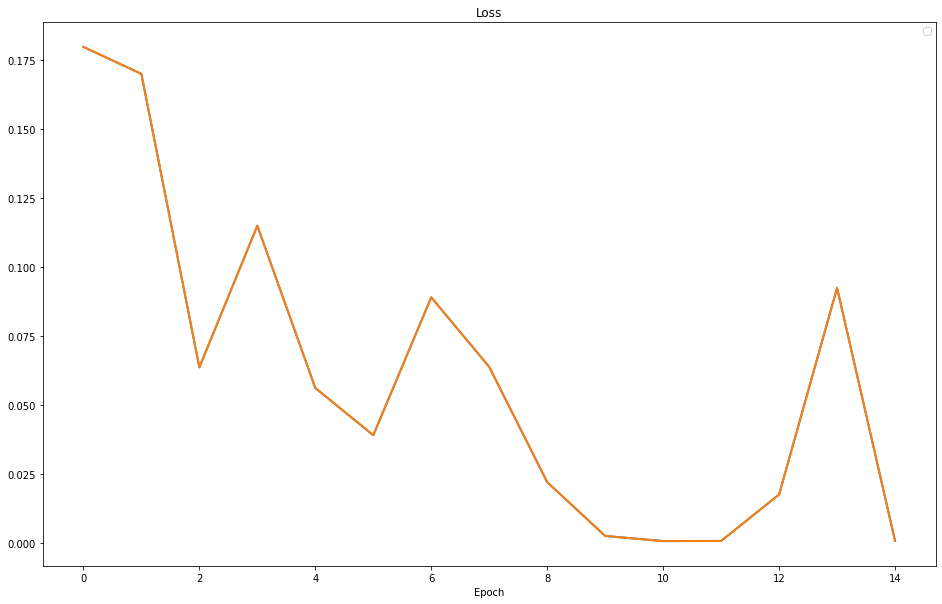

In [40]:
plt.figure(figsize=(16, 10))
plt.title("Loss")
plt.plot(range(max_epochs), losses['train'], linewidth=2)
plt.plot(range(max_epochs), losses['valid'], linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

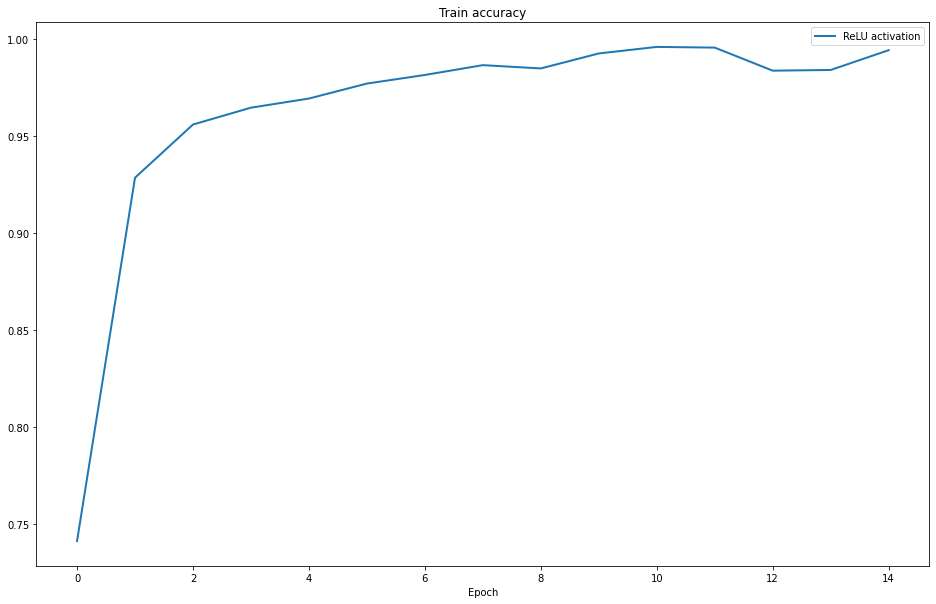

In [41]:
plt.figure(figsize=(16, 10))
plt.title("Train accuracy")
plt.plot(range(max_epochs), accuracy['train'], label="ReLU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [42]:
test_filenames = []
for (dirpath, dirnames, filenames) in walk('/kaggle/input/testbiometry/test'):
    test_filenames.extend(filenames)
    break

In [43]:
test = []
for name in notebook.tqdm(test_filenames):
    path = '/kaggle/input/testbiometry/test/' + name
    y, sr = librosa.load(path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64,
                                    fmax=8000) #генерим признаки для спектрограммы
    S_dB = torch.tensor(librosa.power_to_db(S, ref=np.max))
    S_dB = torch.cat((S_dB, torch.zeros((64, 700-len(S_dB[0])))), dim=1)
    test.append(S_dB)

  0%|          | 0/3413 [00:00<?, ?it/s]

In [44]:
test_data = torch.stack(test)

In [45]:
test_labels = torch.zeros(3413)
test_dataset = TensorDataset(test_data[:, None, :], test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=2)

In [46]:
answers = np.array([])
for x_batch, y_batch in test_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    model.eval()
    with torch.no_grad():
        outp = model(x_batch)
        preds = outp.argmax(-1).cpu().numpy()
        answers = np.append(answers, preds)

In [47]:
answers

array([1., 0., 0., ..., 1., 0., 0.])

In [48]:
submission = pd.DataFrame({'id': test_filenames, 'gender': answers})

In [49]:
submission['id'] = submission['id'].apply(lambda x: x[:len(x) - 4])
submission['gender'] = submission['gender'].astype(int)
submission

,id,gender
0,1ea0ab87d4801a3d34098adf071fdb9c,1
1,d3fdc6a56053b6e49d9ce114f90e4559,0
2,3ca1699c507cb3ea0149039dd4614059,0
3,ebe75d472e7aff759fb8b9b67cfe1f80,0
4,0f42a84e01d15bfc4924aed1558ea19f,0
...,...,...
3408,b7ccb58117ec1c00388b33690dd0435c,0
3409,a080d00ac93c2a2b82849d12f6ecf13e,1
3410,3af328af7d22ec000438c798a80463fc,1
3411,72174ed873aa4a03b2a1740db5aba36d,0


In [50]:
submission.to_csv('answer.tsv', header=None, index=False, sep='\t')

## Вывод

Таким образом были звуковые данные были преобразованы, из них удалось достать фичи, чтобы обучить различные модели. Лучше всего показала себя сверточная сеть 